<a href="https://colab.research.google.com/github/ludlev2/ml_project_cse204/blob/main/Datasets-under-consideration/London/RQ1_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima

In [87]:
def plot_decomp(timeseries: pd.DataFrame) -> None:
  result = seasonal_decompose(timeseries, model='additive')

  fig = plt.figure()  
  fig = result.plot()  
  fig.set_size_inches(15, 12)


## PREPROCESSING

In [88]:
df = pd.read_csv('UK_international-visits.csv')

regions = ['North', 'Midlands', 'East', 'South', 'London']
london = ['LONDON']
south = ['SOUTH WEST', 'SOUTH EAST', 'SOUTHERN ENGLAND', ' CHANNEL ISLANDS',  ' ISLE OF MAN']
east = ['EAST OF ENGLAND', 'REST OF ENGLAND']
midlands = ['WEST MIDLANDS', 'EAST MIDLANDS', 'CENTRAL ENGLAND', 'YORKSHIRE']
north = ['NORTH EAST', 'NORTH WEST', ' NORTHERN IRELAND', 'SCOTLAND', 'WALES', "ENGLAND'S NORTH COUNTRY"]

#map regions to areas
df['area'] = df['area'].replace(london, 'London')
df['area'] = df['area'].replace(south, 'South')
df['area'] = df['area'].replace(east, 'East')
df['area'] = df['area'].replace(midlands, 'Midlands')
df['area'] = df['area'].replace(north, 'North')

#drop 'ALL STAYING VISITS' and 'OIL RIGS/TRAVELLING' and 'TOTAL ENGLAND'
df = df[df.area != 'ALL STAYING VISITS']
df = df[df.area != ' OIL RIGS/TRAVELLING']
df = df[df.area != 'TOTAL ENGLAND']

# combine the year and quarter columns
quarters = df['quarter'].unique().astype(str)

#map quarters to end dates
mapping = {
    quarters[0]:'03-31', 
    quarters[1]:'06-30', 
    quarters[2]:'09-30',
    quarters[3]:'12-31'
}
df['quarter'] = df['quarter'].replace(mapping)

#combine year and quarter columns by adding them together, casting them as floats
#map '2019P' to 2019
df['year'] = df['year'].replace('2019P', '2019')
df['year'] = df['year'].astype(str)
df['date'] = (df['year'] + '-' + df['quarter'])

#group by date and area, summing the visits
df = df.groupby(['date', 'area']).sum().reset_index()
#drop all columns execpt date, area and visits
df = df[['date', 'area', 'visits']]
london = df[df.area == 'London']
london.drop(columns=['area'], inplace=True)
london['date'] = pd.to_datetime(london['date'])
print(london)

/var/folders/d3/ry6v0r7j28d4wdqwrz_hvdqc0000gn/T/ipykernel_11593/3659142353.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UK_international-visits.csv')


          date       visits
1   2002-03-31  2194.519332
6   2002-06-30  2996.205639
11  2002-09-30  3501.537392
16  2002-12-31  2911.119717
21  2003-03-31  2529.722468
..         ...          ...
331 2018-09-30  5246.352969
336 2018-12-31  4832.631090
341 2019-03-31  4239.713399
346 2019-06-30  5049.670833
351 2019-09-30  5747.252751

[71 rows x 2 columns]


/var/folders/d3/ry6v0r7j28d4wdqwrz_hvdqc0000gn/T/ipykernel_11593/3659142353.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london.drop(columns=['area'], inplace=True)
/var/folders/d3/ry6v0r7j28d4wdqwrz_hvdqc0000gn/T/ipykernel_11593/3659142353.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london['date'] = pd.to_datetime(london['date'])


## INPUT

In [89]:
visits = pd.read_csv("uk_international_visits_clean.csv", parse_dates=[0]).set_index('date')
visits = london.set_index('date')
#filter visits to only include London
exog = pd.read_csv("uk_gdp_growth.csv", parse_dates=[0]).set_index('date')

In [90]:
exog["GDP_Growth_QoQ_1"] = exog["GDP_Growth_QoQ"].shift(1).fillna(method="bfill").values
exog["GDP_Growth_QoQ_2"] = exog["GDP_Growth_QoQ"].shift(2).fillna(method="bfill").values
exog["GDP_Growth_QoQ_3"] = exog["GDP_Growth_QoQ"].shift(3).fillna(method="bfill").values

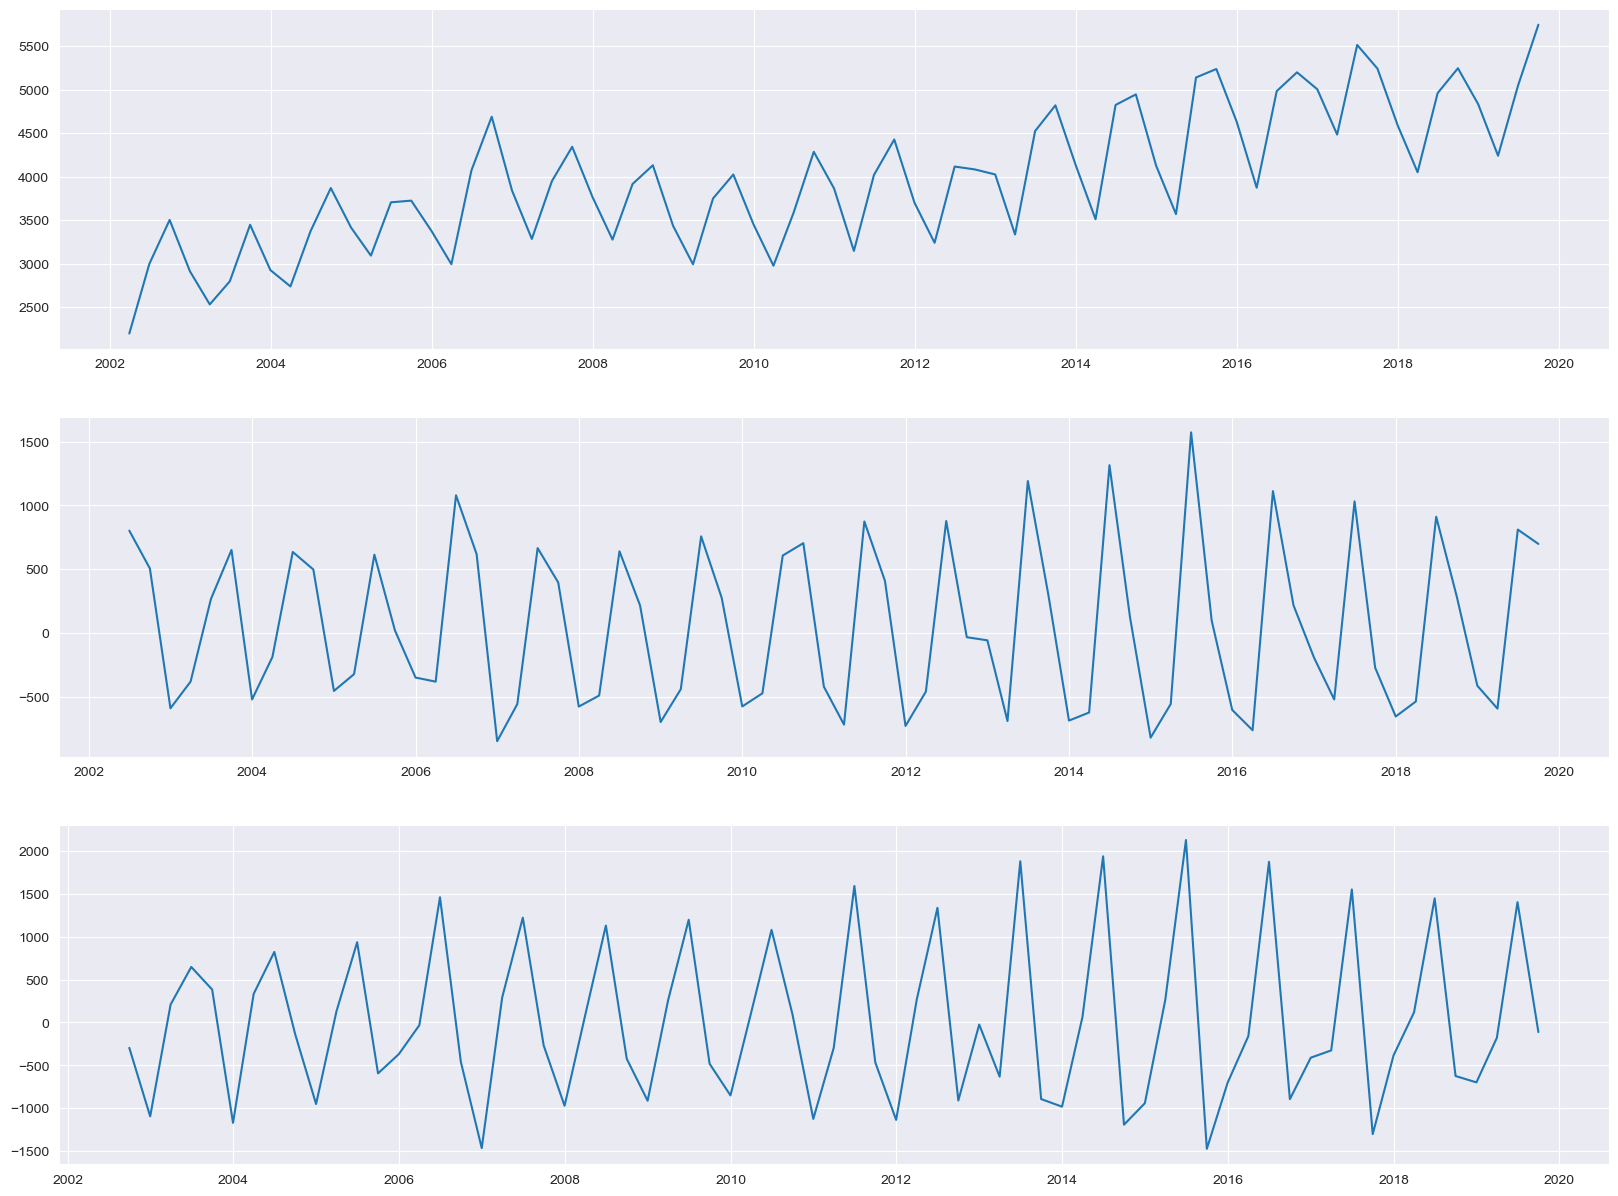

In [91]:
# We look at the original TS, 1st and 2nd difference to check stationarity
visits_diff_1 = visits.diff().dropna()
visits_diff_2 = visits.diff().diff().dropna()

fig, axs = plt.subplots(nrows=3, figsize=(20, 15))

axs[0].plot(visits)
axs[1].plot(visits_diff_1)
axs[2].plot(visits_diff_2)

Stationarity in time series refers to the property where the statistical characteristics of the data (mean, variance, autocorrelation) do not change over time. This is an important property for many time series models and statistical analyses.

Looking at the first and second difference of a time series can help determine if it is stationary or not.

The first difference essentially calculates the change between consecutive time periods. If the first difference looks like "white noise" (random fluctuations around 0), that indicates the original time series may be (trend) stationary.

The second difference calculates the change in the first difference. If the second difference looks like white noise, that implies the original time series has no trends or seasonal patterns, and is likely weakly stationary.

## SPLIT

In [76]:
visits_train = visits[visits.index < datetime(2011, 7, 1)]
visits_test  = visits[visits.index >= datetime(2011, 7, 1)]

exog_train = exog[exog.index < datetime(2012, 7, 1)]
exog_test = exog[exog.index >= datetime(2012, 7, 1)]

## PLOTS and EDA

<Figure size 640x480 with 0 Axes>

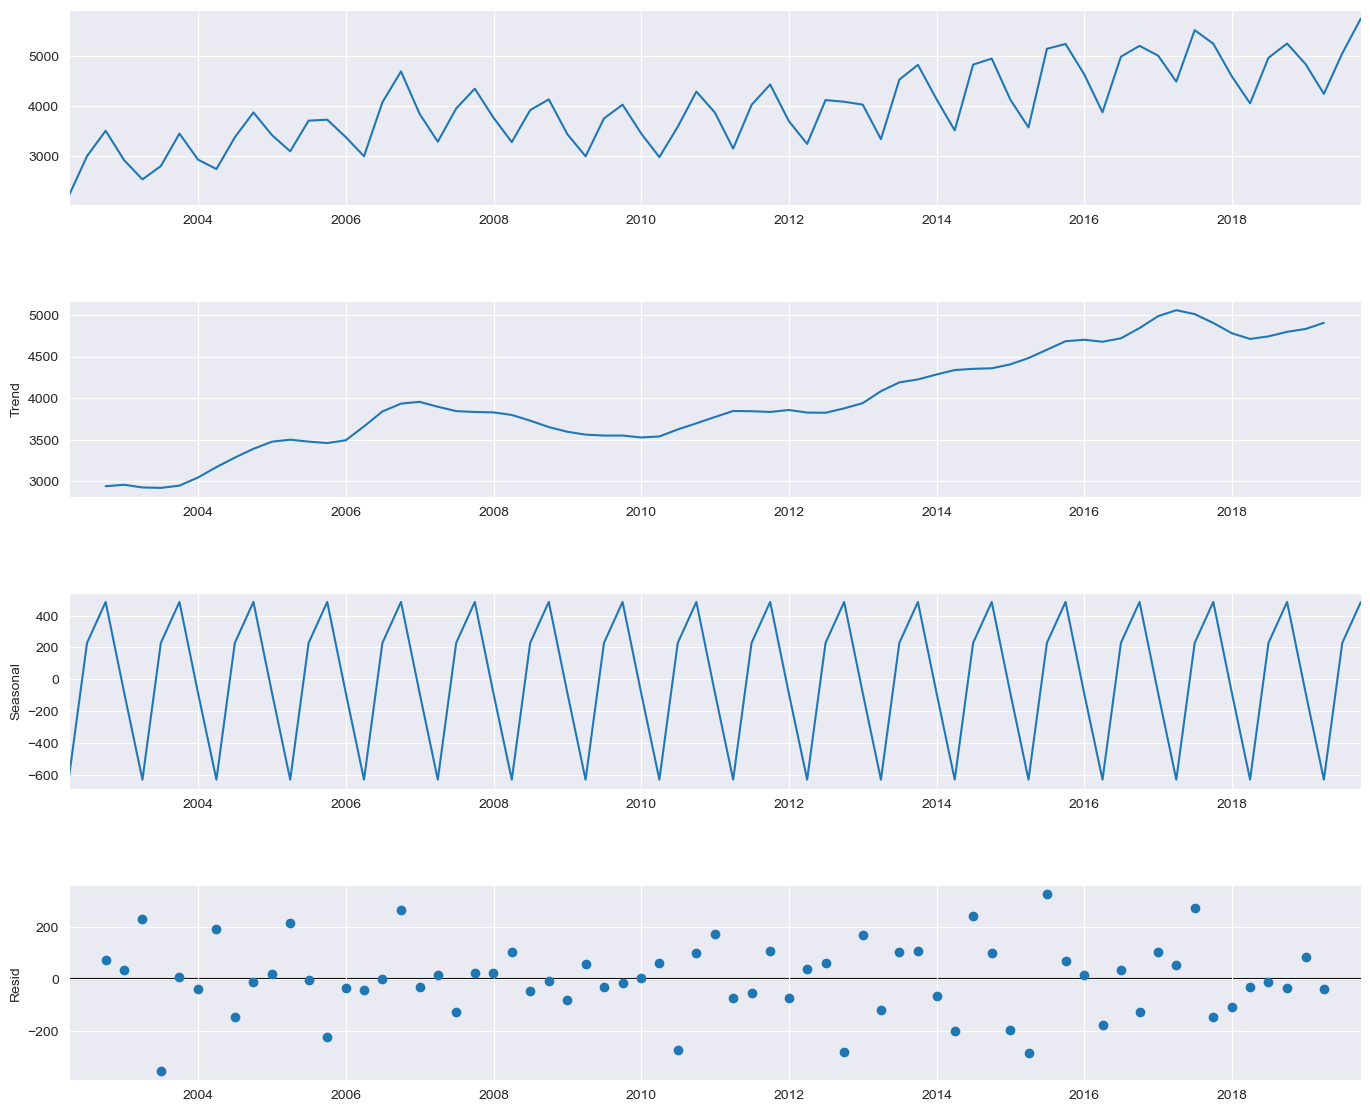

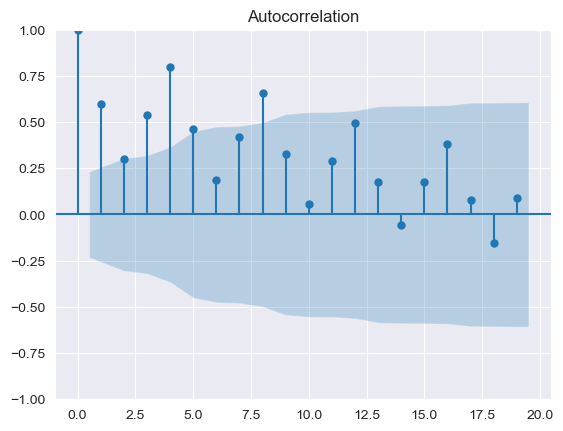

In [77]:
# Plot decomposition into trend + seasonality + noise, plot acf to check autocorrelation
plot_decomp(visits)
x = plot_acf(visits)

The plot_decomp() function is decomposing the time series into its components:

- The trend component shows the long-term upward or downward movement of the data.
- The seasonality component shows any repetitive, periodic fluctuations. This could be daily, weekly, monthly, etc. patterns.
-  The noise or residual component shows the remaining random fluctuations after removing the trend and seasonality.

These components help understand the underlying structure of the time series and identify potential non-stationarities.

The plot_acf() function plots the autocorrelation function (ACF) of the time series. The ACF shows the correlation of the time series with its own past values.

- If the ACF decays quickly and the values fall within the confidence interval bands, that indicates the time series is weakly stationary (no long-term correlation).

- If the ACF decays slowly and the correlations persist for many lags, that indicates non-stationarity due to trends or seasonality.

- We can see that in this case the autocorrelation shows seasonality every 4 periods (ie. Q1 in one year highly resembles Q1 in other years. This remains true for other quarters as well. Moreover, there is also high correlation for 3, 7, 11 etc., which could be an indication of the seasons (slightly out of lag with quarters)



<Figure size 640x480 with 0 Axes>

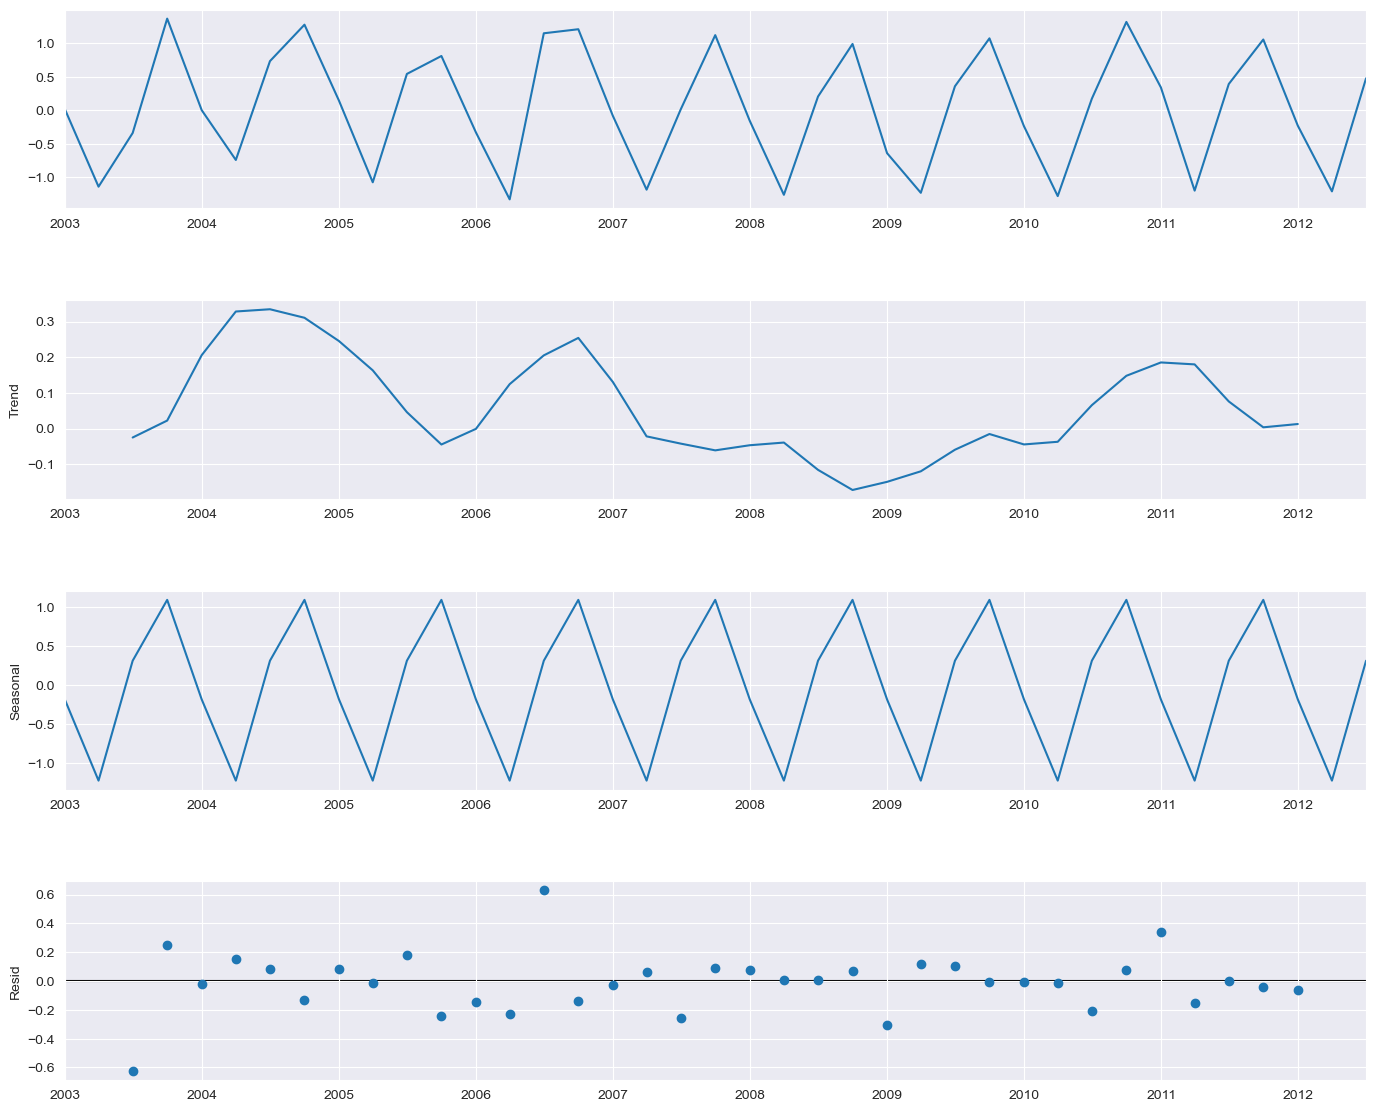

In [78]:
# Detrend and plot again
visits_detrended = (visits_train - visits_train.rolling(4).mean()) / visits_train.rolling(4).std()
plot_decomp(visits_detrended.dropna())

This detrending works as follows:

1. We calculate a 4-period rolling mean of the time series using .rolling(4).mean()
2. We subtract this rolling mean from the original time series to remove the trend. This gives us the detrended series.
3. We also calculate a 4-period rolling standard deviation using .rolling(4).std()
4. We divide the detrended series by the rolling standard deviation to normalize the data.

The effects of this detrending are:

- The trend component in the decomposition plot is now close to 0. Most of the trend has been removed.

- The seasonality and noise components now show the overall fluctuations in the data, without the upward/downward trend.

- This detrending transformation helps achieve trend stationarity. The statistical properties (mean, variance) of the detrended series will now be relatively constant over time.

- This allows us to use standard time series models that require stationarity, like ARIMA and exponential smoothing, on the detrended data.

- We can then forecast the detrended series and add back the original trend to obtain forecasts for the original, non-stationary time series.

<Figure size 640x480 with 0 Axes>

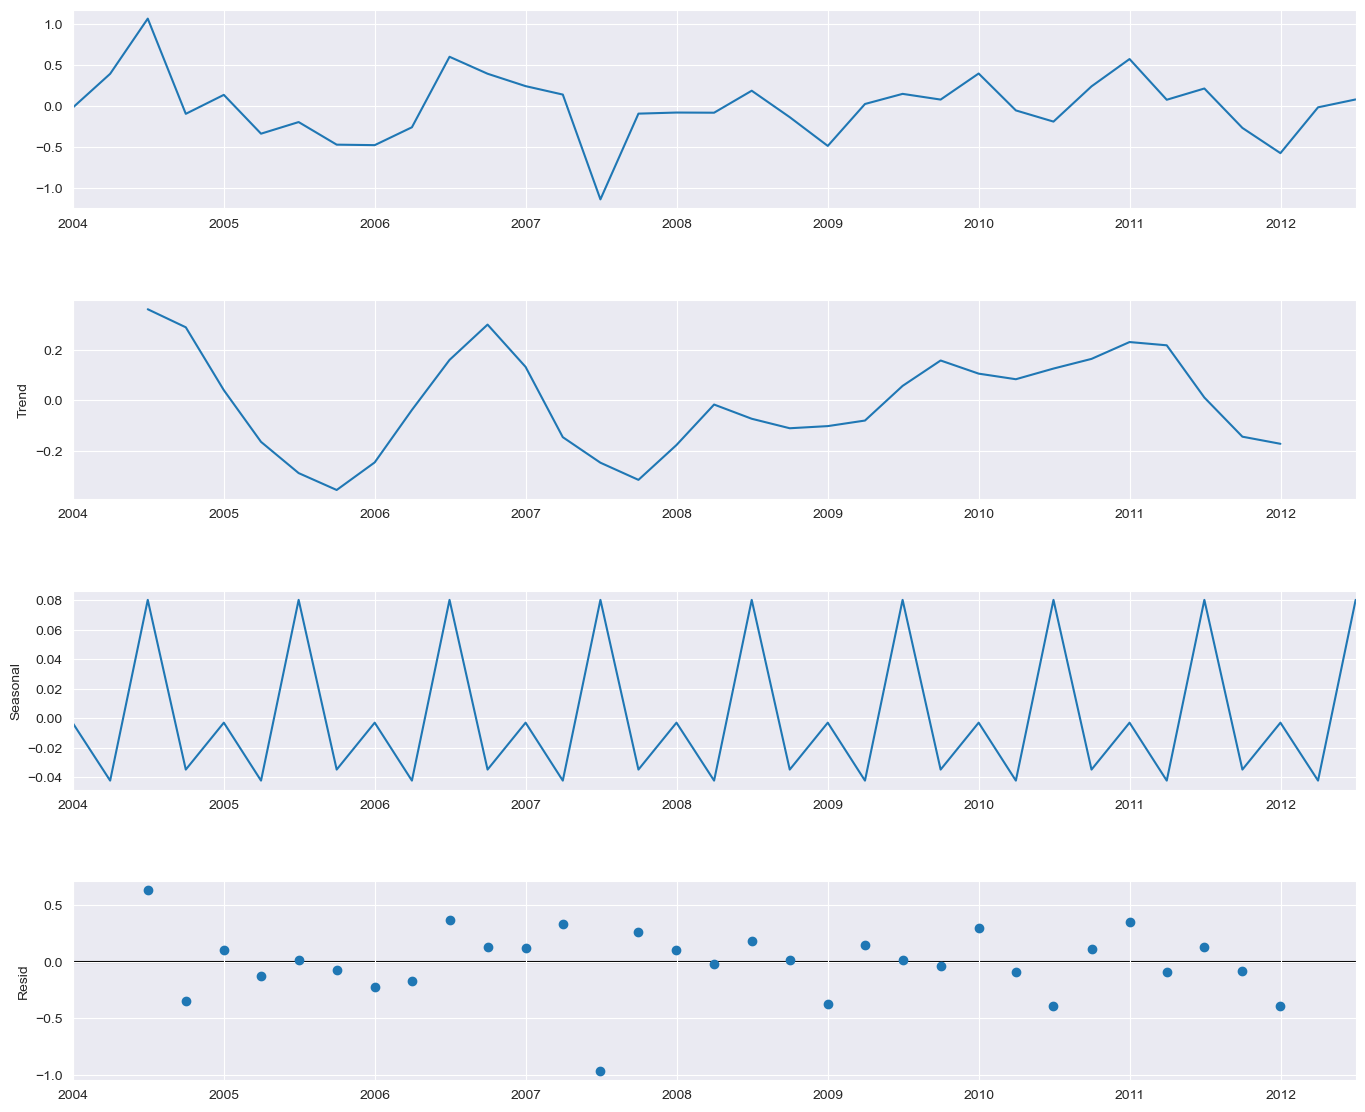

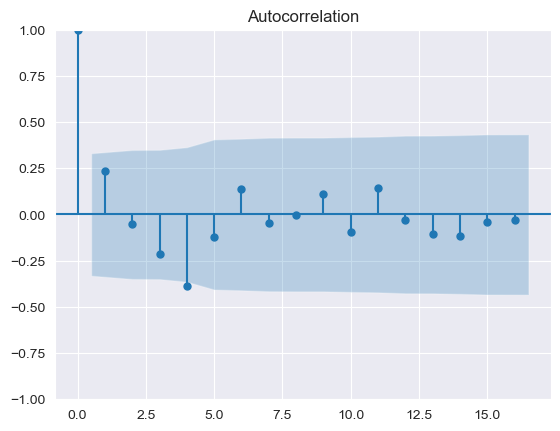

In [79]:
# Remove seasonality, check acf to ensure it is gone
visits_lagged = (visits_detrended - visits_detrended.shift(4)).dropna()
plot_decomp(visits_lagged)
x = plot_acf(visits_lagged)

We are now removing seasonal patterns from the detrended time series:

- We calculate the lag-4 difference of the detrended series using .shift(4). This subtracts the value 4 periods ago from the current value.

- Taking the lag-4 difference removes any patterns that repeat every 4 periods, which is likely the monthly seasonality in this data.

- We plot the decomposition of this differenced series using plot_decomp(). We can see that the seasonality component is now close to 0, indicating most of the seasonality has been removed.

- We plot the ACF of the differenced series using plot_acf(). We see that the ACF decays quickly and the correlations fall within the confidence intervals. This indicates the series is now stationary (no trend or seasonality).


Thus, the statistical properties of the series (mean, variance, autocorrelation) will now be relatively constant over time, once we account for the seasonal differencing.

In [80]:
results = {
    'train': adfuller(visits_train['visits']),
    'test': adfuller(visits_test['visits'])
}

for result in results:
  # Extract the test statistic and p-value
  test_statistic = results[result][0]
  p_value = results[result][1]

  # Print the results
  print(f"___{result}___")
  print(f'Test statistic: {test_statistic:.4f}')
  print(f'p-value: {p_value:.4f}')

___train___
Test statistic: -1.5871
p-value: 0.4901
___test___
Test statistic: -1.5937
p-value: 0.4868


The Augmented Dickey-Fuller (ADF) test is used to test the null hypothesis that a time series is a random walk or contains a unit root (is non-stationary). The alternative hypothesis is that the series is stationary.

The test statistic and p-value are:

- A more negative test statistic provides stronger evidence against the null hypothesis of a random walk.

- A lower p-value (typically <0.05) indicates the null hypothesis of a random walk can be rejected, meaning the series is likely stationary.

The results show:

- For both train and test sets, the test statistics are small (-1.5 to -1.6) and the p-values are high (0.49).

- This indicates we cannot reject the null hypothesis that the series is a random walk or contains a unit root. There is not enough evidence to conclude the series is stationary.

This is consistent with our visual observations of trends and seasonality in the time series, indicating it is a random walk

In [81]:
t_statistic, p_value = ttest_ind(visits_train.diff().dropna(), visits_test.diff().dropna())

float(p_value)

0.9376197175319372

When we have two time series that are both random walks, we can still compare their drift (the rate of change over time) using a t-test.

The t-test will test the null hypothesis that the means of the two series are equal, against the alternative hypothesis that their means are different.

By taking the first difference of each series, we remove any trends and seasonality, leaving just the random fluctuations in each period. These random fluctuations represent the drift of the respective random walks.

Therefore, by performing a t-test on the first differences of the two series, we can determine if:

Their drifts (average changes per period) are equal, implying they have the same rate of change over time. In this case we fail to reject the null hypothesis.

Their drifts are significantly different, implying they have different rates of change over time. In this case we reject the null hypothesis.

The t-statistic measures how separated the means of the two series are, relative to the variation in the data. A larger absolute value indicates a greater difference between the means.

The p-value tells us if that difference is statistically significant. A lower p-value indicates a statistically significant difference, allowing us to reject the null hypothesis of equal drifts, but in this case the p value is 0.938, which we obviously cannot reject.

## MODELLING

In [82]:
# automatically select best ARIMA parameters
stepwise_model = auto_arima(
    visits_train, X=exog_train, start_p=1, start_q=1,
    max_p=3, max_q=3, m=4,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
)

Performing stepwise search to minimize aic


/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[4]             : AIC=513.149, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=523.097, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=519.893, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=512.597, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=525.016, Time=0.04 sec


/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,1)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=inf, Time=0.19 sec


/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[4]             : AIC=519.847, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=512.525, Time=0.15 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=519.340, Time=0.13 sec
 ARIMA(0,1,2)(1,1,1)[4]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,1,2)[4]             : AIC=514.881, Time=0.21 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=518.176, Time=0.15 sec
 ARIMA(0,1,2)(1,1,2)[4]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=515.079, Time=0.18 sec


/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(0,1,3)(0,1,1)[4]             : AIC=514.719, Time=0.19 sec
 ARIMA(1,1,3)(0,1,1)[4]             : AIC=516.826, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[4] intercept   : AIC=514.429, Time=0.18 sec

Best model:  ARIMA(0,1,2)(0,1,1)[4]          
Total fit time: 3.442 seconds


/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [83]:
model = ARIMA(
    visits_train, exog=exog_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)
).fit()

/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/Users/ad1thya_r/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<AxesSubplot:>

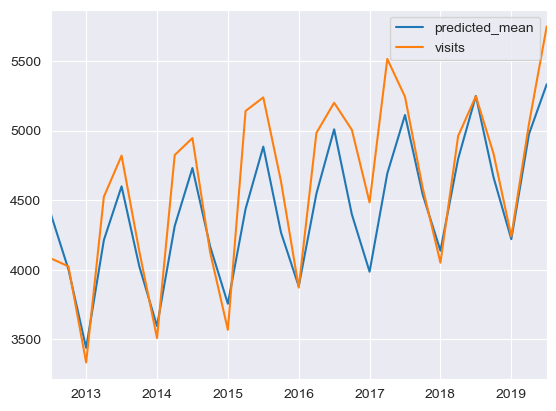

In [84]:
# MAKE A BETTER CHART

pd.concat(
    [
      pd.DataFrame(
          model.predict(start=visits_test.index[0], end=visits_test.index[-1], exog=exog_test)
      ),
      visits_test
    ],
    axis=1
).plot()

<AxesSubplot:>

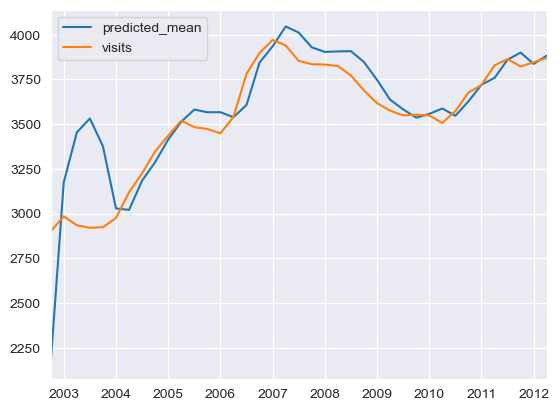

In [85]:
pd.concat(
    [
      pd.DataFrame(
          model.predict(start=visits_train.index[0], end=visits_train.index[-1], exog=exog_train)
      ).rolling(4).mean().dropna(),
      visits_train.rolling(4).mean().dropna(),
    ],
    axis=1
).plot()

In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            visits   No. Observations:                   42
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -298.880
Date:                           Sun, 28 May 2023   AIC                            609.759
Time:                                   23:20:54   BIC                            619.425
Sample:                               03-31-2002   HQIC                           613.167
                                    - 06-30-2012                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
GDP_Growth_QoQ     228.2268    230.329      0.991      0.322    -223.210     679.663
GDP_Growth_QoQ_1   281.7892    283.234      0.995      0.320    -273.339     836.918
GDP_Growth_QoQ_2  -538.3152    235.421     -2.287      0.022    -999.733     -76.898
GDP_Growth_QoQ_3   458.8387    178.322      2.573      0.010     109.334     808.343
ma.S.L4             -0.2738      0.141     -1.942      0.052      -0.550       0.003
sigma2            5.729e+05   1.85e+05      3.097      0.002     2.1e+05    9.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.22   Prob(JB):                         0.42
Heteroskedasticity (H):               1.19   Skew:                            -0.06
Prob(H) (two-sided):                  0.77   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""